In [62]:
import os
from itertools import combinations

import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [63]:
def calculate_histogram(image_path):
    """Calculează histograma culorilor normalizată (HSV) pentru o imagine."""

    try:
        # 1. Citeste imaginea
        image = cv2.imread(image_path)
        if image is None:
            print(f"Eroare: Nu s-a putut citi imaginea {image_path}. O sarim.")
            return None

        # 2. Convertește la spațiul de culoare HSV (mai bun pentru descrierea culorilor)
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # 3. Calculează histograma (ex: H, S pe 8, 8 bins)
        # channels=[0, 1] pentru H și S; histSize=[8, 8] pentru 8 bin-uri pe fiecare
        # ranges=[0, 180, 0, 256] pentru H (0-180) și S (0-256)
        hist = cv2.calcHist([hsv], [0, 1], None, [8, 8], [0, 180, 0, 256])

        # 4. Normalizează histograma (pentru a fi insensibilă la mărimea imaginii)
        hist = cv2.normalize(
            hist, hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX
        ).flatten()
        return hist
    except Exception as e:
        print(f"A apărut o eroare la procesarea {image_path}: {e}")
        return None

In [64]:
def find_similar_images(
    database_folder,
    query_image_path,
    x_top=5,
    supported_extensions=(".jpg", ".jpeg", ".png", ".bmp", ".tiff"),
):
    """
    Găsește cele mai similare x imagini dintr-un folder la o imagine dată.

    :param database_folder: Calea către folderul cu imaginile bazei de date.
    :param query_image_path: Calea către imaginea de referință (de interes).
    :param x_top: Numărul de imagini similare de returnat.
    :return: O listă de tuple (cale_imagine, scor_similaritate).
    """

    # 1. Calculează histograma imaginii de interes (query)
    query_hist = calculate_histogram(query_image_path)
    if query_hist is None:
        print("\n🚫 Nu se poate continua, imaginea de interes nu a putut fi procesată.")
        return []

    # 2. Procesează imaginile din baza de date
    db_histograms = {}
    print(f"🔍 Procesez imaginile din directorul: {database_folder}...")

    for filename in os.listdir(database_folder):
        # Ignoră imaginea de interes dacă se află în folderul bazei de date
        if filename == os.path.basename(query_image_path):
            continue

        if filename.lower().endswith(supported_extensions):
            path = os.path.join(database_folder, filename)
            hist = calculate_histogram(path)
            if hist is not None:
                db_histograms[path] = hist

    if not db_histograms:
        print("\n⚠️ Nu s-au găsit imagini valide în baza de date.")
        return []

    # 3. Compară histogramele
    results = {}

    # Metoda cv2.compareHist(hist1, hist2, method)
    # Metoda cv2.HISTCMP_CHISQR (Chi-Square) => Scorul mai MIC înseamnă similaritate MAI MARE.
    # Alternativ, se poate folosi corelația (cv2.HISTCMP_CORREL) unde scorul MAI MARE înseamnă similaritate MAI MARE.

    for path, hist in db_histograms.items():
        distance = cv2.compareHist(query_hist, hist, cv2.HISTCMP_CHISQR)
        results[path] = distance

    # 4. Sortează rezultatele
    # Sortăm după valoarea distanței (scorul) în ordine ascendentă,
    # deoarece o distanță MAI MICĂ înseamnă o similaritate MAI MARE.
    sorted_results = sorted(results.items(), key=lambda item: item[1])

    return sorted_results[:x_top]

In [65]:
def analyze_dataset(
    database_folder,
    query_image_path,
    supported_extensions=(".jpg", ".jpeg", ".png", ".bmp", ".tiff"),
):
    db_histograms = []

    for filename in os.listdir(database_folder):
        if filename.lower().endswith(supported_extensions):
            path = os.path.join(database_folder, filename)
            hist = calculate_histogram(path)
            if hist is not None:
                db_histograms.append(hist)

    if not db_histograms:
        print("⚠️ Nu s-au găsit imagini valide pentru analiză.")
        return

    # 2. Compararea histogramei query cu toate histogramele (Chi-Square)
    query_hist = calculate_histogram(query_image_path)

    # 3. Vizualizarea histogramei query față de top 3 imagini similare
    top_similar = find_similar_images(database_folder, query_image_path, x_top=3)
    plt.figure(figsize=(12, 4))
    plt.plot(query_hist, label="Query", color="red", linewidth=2)
    for i, (path, _) in enumerate(top_similar):
        hist = calculate_histogram(path)
        plt.plot(hist, label=f"Top {i + 1}: {os.path.basename(path)}")
    plt.title("Compararea histogramelor (Query vs Top 3 similare)")
    plt.xlabel("Bins HxS (8x8)")
    plt.ylabel("Valoare normalizată")
    plt.legend()
    plt.show()

# Tests and Results

🔍 Procesez imaginile din directorul: test_custom...

✨ Cele mai similare 3 imagini cu 'face-3-center.jpg':
#1: face-23-center.jpg
  Scor similaritate (Chi-Square Dist.): 0.0683


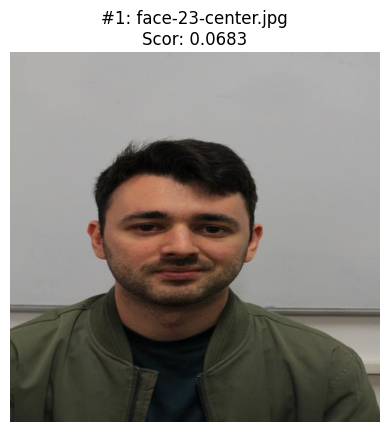

--------------------
#2: face-23-left.jpg
  Scor similaritate (Chi-Square Dist.): 0.1119


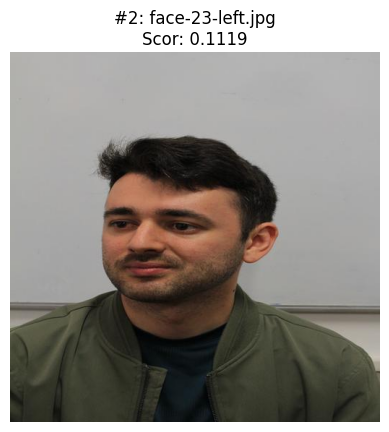

--------------------
#3: face-3-left.jpg
  Scor similaritate (Chi-Square Dist.): 0.3397


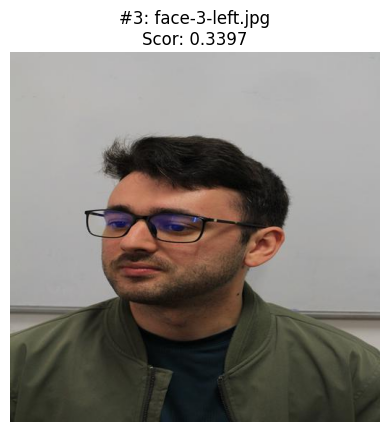

--------------------
🔍 Procesez imaginile din directorul: test_custom...


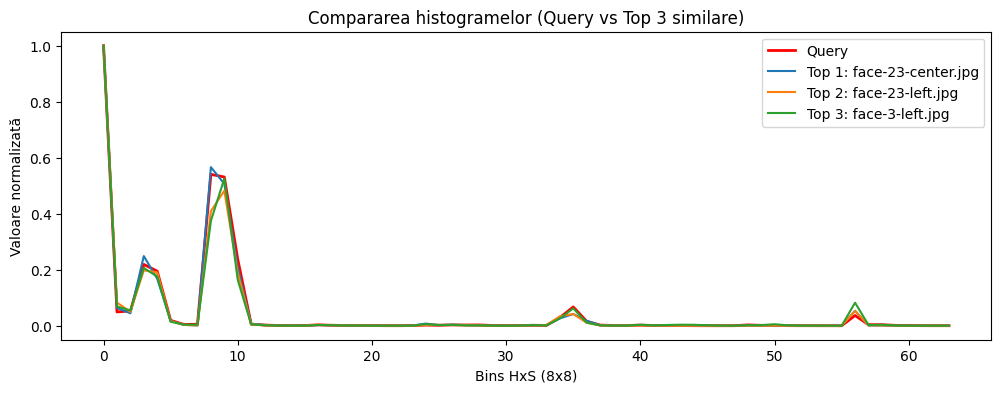

In [66]:
DATABASE_DIR = "test_custom"
QUERY_IMAGE = "test_custom/face-3-center.jpg"
TOP_X = 3
SUPPORTED_EXTENSIONS = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")

similar_images = find_similar_images(
    DATABASE_DIR, QUERY_IMAGE, TOP_X, SUPPORTED_EXTENSIONS
)

print("\n" + "=" * 50)
print(
    f"✨ Cele mai similare {len(similar_images)} imagini cu '{os.path.basename(QUERY_IMAGE)}':"
)
print("=" * 50)

if similar_images:
    for i, (path, score) in enumerate(similar_images):
        print(f"#{i + 1}: {os.path.basename(path)}")
        print(f"  Scor similaritate (Chi-Square Dist.): {score:.4f}")

        plt.figure(), plt.imshow(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))
        plt.title(f"#{i + 1}: {os.path.basename(path)}\nScor: {score:.4f}")
        plt.axis("off")
        plt.show()
        print("-" * 20)
else:
    print("Nicio imagine similară nu a fost găsită.")

analyze_dataset(DATABASE_DIR, QUERY_IMAGE, SUPPORTED_EXTENSIONS)

✅ 113 imagini procesate cu succes.


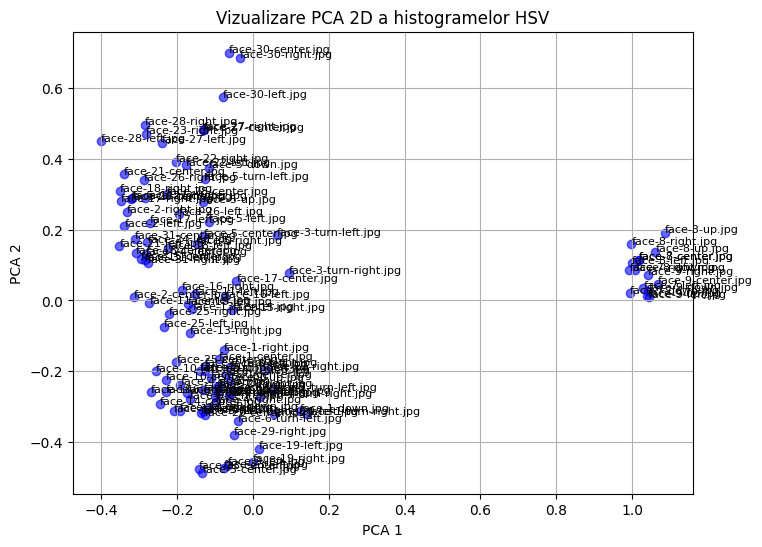

In [67]:
# 1. Calculăm histogramele tuturor imaginilor
image_paths = []
histograms = []

for filename in os.listdir(DATABASE_DIR):
    if filename.lower().endswith(SUPPORTED_EXTENSIONS):
        path = os.path.join(DATABASE_DIR, filename)
        hist = calculate_histogram(path)
        if hist is not None:
            image_paths.append(path)
            histograms.append(hist)

histograms = np.array(histograms)
print(f"✅ {len(histograms)} imagini procesate cu succes.")

# 2. Calculăm distanțele Chi-Square pentru toate perechile de imagini
distances = []
for h1, h2 in combinations(histograms, 2):
    d = cv2.compareHist(h1, h2, cv2.HISTCMP_CHISQR)
    distances.append(d)

# 3. PCA pentru vizualizare 2D
pca = PCA(n_components=2)
hist_2d = pca.fit_transform(histograms)

plt.figure(figsize=(8, 6))
plt.scatter(hist_2d[:, 0], hist_2d[:, 1], c="blue", alpha=0.6)
for i, path in enumerate(image_paths):
    plt.text(hist_2d[i, 0], hist_2d[i, 1], os.path.basename(path), fontsize=8)
plt.title("Vizualizare PCA 2D a histogramelor HSV")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()
